https://datascience.stackexchange.com/questions/32480/how-does-generalised-advantage-estimation-work
https://lilianweng.github.io/lil-log/2018/02/19/a-long-peek-into-reinforcement-learning.html#combining-td-and-mc-learning
https://arxiv.org/pdf/1506.02438.pdf
https://github.com/higgsfield/RL-Adventure-2
http://www.breloff.com/DeepRL-OnlineGAE/
https://arxiv.org/pdf/1804.02717.pdf
https://ewrl.files.wordpress.com/2015/02/ewrl12_2015_submission_18.pdf
https://github.com/Kaixhin/Dist-A3C
https://github.com/Kaixhin/Dist-A3C/blob/master/client.py

In [14]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torch.distributions as distributions

import matplotlib.pyplot as plt
import numpy as np
import random
import gymnasium as gym

In [15]:
# ----------------------------
# Device setup
# ----------------------------
def get_device():
    """Select available device (CUDA, MPS for Apple, or CPU)."""
    if torch.cuda.is_available():
        device = torch.device("cuda")
    elif torch.backends.mps.is_available():  # macOS Metal
        device = torch.device("mps")
    elif torch.version.hip is not None and torch.cuda.is_available():
        device = torch.device("cuda")  # AMD ROCm usually appears as CUDA device
    else:
        device = torch.device("cpu")
    print(f"Using device: {device}")
    return device

In [16]:
# ----------------------------
# Seeding for reproducibility
# ----------------------------
def set_seed(seed):
    """Sets seed for reproducibility across libraries and devices."""
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)
        torch.backends.cudnn.deterministic = True
        torch.backends.cudnn.benchmark = False

In [17]:
class MLP(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, dropout = 0.5):
        super().__init__()
        self.fc_1 = nn.Linear(input_dim, hidden_dim)
        self.fc_2 = nn.Linear(hidden_dim, output_dim)
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, x):
        x = self.fc_1(x)
        x = self.dropout(x)
        x = F.relu(x)
        x = self.fc_2(x)
        return x

In [18]:
class ActorCritic(nn.Module):
    def __init__(self, actor, critic):
        super().__init__()
        self.actor = actor
        self.critic = critic
        
    def forward(self, state):
        action_pred = self.actor(state)
        value_pred = self.critic(state)
        return action_pred, value_pred

In [19]:
def init_weights(m):
    if type(m) == nn.Linear:
        torch.nn.init.xavier_normal_(m.weight)
        m.bias.data.fill_(0)

In [20]:
def train_episode(env, policy, optimizer, gamma, trace_decay, device):
    """Train policy for one episode."""      
    policy.train()
    log_prob_actions, rewards, values = [], [], []
    done = False
    state, _ = env.reset()
    while not done:
        state = torch.tensor(state, dtype=torch.float32, device=device).unsqueeze(0)
        action_pred, value_pred = policy(state)
        action_prob = F.softmax(action_pred, dim = -1)
        dist = distributions.Categorical(action_prob)
        action = dist.sample()

        next_state, reward, done, truncated, _ = env.step(action.item())
        done = done or truncated

        log_prob_actions.append(dist.log_prob(action))
        rewards.append(reward)
        values.append(value_pred.squeeze(0))
        state = next_state
    
    log_prob_actions = torch.stack(log_prob_actions)
    values = torch.cat(values)
    returns = calculate_returns(rewards, gamma, device, True)
    # Note: calculate_advantages takes in rewards, not returns!
    # advantages = calculate_advantages(returns, values, False)
    advantages = calculate_advantages_old(rewards, values, gamma, trace_decay, device, True)
    policy_loss, value_loss = update_policy(advantages, log_prob_actions, returns, values, optimizer)

    return policy_loss, value_loss, sum(rewards)

In [21]:
def train_episode_batches(env, policy, optimizer, n_episodes, gamma, lam, device):
    (states_b, actions_b, old_log_probs_b,
     returns_b, values_b, episode_rewards) = collect_batch_episodes(env, policy, n_episodes, gamma, device)
    # print(f'{len(episode_rewards)} {old_log_probs_b.shape} {returns_b.shape} {values_b.shape}')
    # One PPO-style or A2C update:
    advantages_b = calculate_advantages_old(returns_b, values_b, gamma, lam, device, True)
    # print(f'{advantages_b.shape} {old_log_probs_b.shape} {returns_b.shape} {values_b.shape}')
    p_loss, v_loss = update_policy_old(advantages_b, old_log_probs_b, returns_b, values_b, optimizer)
    return p_loss, v_loss, sum(episode_rewards)
    
def collect_batch_episodes(env, policy, n_episodes, gamma, device):
    """
    Collect n_episodes complete episodes (sequentially) and return concatenated
    tensors for states, actions, old_log_probs, returns, values, and episode rewards.
    """
    states, actions, log_probs_old, returns_list, values, episode_total_rewards = [], [], [], [], [], []

    for _ in range(n_episodes):
        ep_states, ep_actions, ep_log_probs, ep_rewards, ep_values = [], [], [], [], []
        done = False
        state, _ = env.reset()

        while not done:
            s_t = torch.tensor(state, dtype=torch.float32, device=device).unsqueeze(0)  # [1, obs]
            logits, value = policy(s_t)  # logits: [1, A], value: [1,1]
            dist = distributions.Categorical(logits=logits)
            action = dist.sample()       # [1]
            logp = dist.log_prob(action) # [1]

            next_state, reward, terminated, truncated, _ = env.step(action.item())
            done = terminated or truncated

            ep_states.append(s_t)                # list of tensors [1,obs]
            ep_actions.append(action.squeeze(0)) # tensor scalar
            ep_log_probs.append(logp.squeeze(0)) # tensor scalar
            ep_rewards.append(reward)
            ep_values.append(value.squeeze(0))   # scalar tensor
            
            state = next_state

        # episode end: compute returns for episode
        ep_returns = calculate_returns(ep_rewards, gamma, device, normalize=False)  # normalized later optionally
        episode_total_rewards.append(sum(ep_rewards))

        # stack episode tensors and append to global lists
        states.append(torch.cat(ep_states, dim=0))         # [T, obs]
        actions.append(torch.stack(ep_actions))            # [T]
        log_probs_old.append(torch.stack(ep_log_probs))    # [T]
        returns_list.append(ep_returns)                    # [T]
        values.append(torch.cat(ep_values).detach())     # [T] detach values when used as baseline

    # concatenate across episodes -> final batch
    states_b = torch.cat(states, dim=0)           # [N, obs]
    actions_b = torch.cat(actions, dim=0)         # [N]
    log_probs_old_b = torch.cat(log_probs_old, dim=0)   # [N]
    returns_b = torch.cat(returns_list, dim=0)    # [N]
    values_b = torch.cat(values, dim=0)           # [N]
    return states_b, actions_b, log_probs_old_b, returns_b, values_b, episode_total_rewards

In [22]:
# ----------------------------
# Training and evaluation
# ----------------------------
def calculate_returns(rewards, gamma, device, normalize=True):
    """Compute discounted returns for an episode."""
    returns = []
    R = 0
    for r in reversed(rewards):
        R = r + gamma * R
        returns.insert(0, R)
    returns = torch.tensor(returns, dtype=torch.float32, device=device)
    if normalize:
        returns = (returns - returns.mean()) / (returns.std() + 1e-8)
    return returns

In [23]:
def calculate_advantages(rewards, values, gamma, lam, device, normalize=True):
    """
    Compute GAE advantages for a single episode.
    - rewards: Python list or 1D tensor of length T (floats)
    - values: 1D tensor of length T (torch, on device)
    Returns:
      advantages: 1D tensor length T on `device`
    """
    # ensure values is a 1D float tensor on device
    values = values.to(device).float().detach()
    T = len(rewards)
    advantages = torch.zeros(T, dtype=torch.float32, device=device)

    # next_value is V_{t+1}. initialize with 0 for terminal state
    next_value, next_adv = 0.0, 0.0  # running advantage for GAE(lambda)
    for t in reversed(range(T)):
        r = float(rewards[t])  # Python float, safe to mix
        v_t = values[t]
        # TD error: delta_t = r_t + gamma * V_{t+1} - V_t
        delta = r + gamma * next_value - v_t
        # GAE recursion: A_t = delta_t + gamma * lambda * A_{t+1}
        next_adv = delta + gamma * lam * next_adv
        advantages[t] = next_adv
        # update next_value for previous timestep
        next_value = v_t.detach().item()

    if normalize:
        adv_mean = advantages.mean()
        adv_std = advantages.std(unbiased=False)  # population std (faster)
        advantages = (advantages - adv_mean) / (adv_std + 1e-8)

    return advantages

def calculate_advantages_old(rewards, values, discount_factor, trace_decay, device, normalize = True):
    # ensure values is a 1D float tensor on device
    values = values.to(device).float()
    advantage, next_value = 0, 0
    num_rewards = len(rewards)
    advantages = torch.zeros(num_rewards, dtype=torch.float32, device=device)

    # for r, v in zip(reversed(rewards), reversed(values)):
    for t in reversed(range(num_rewards)):
        r = float(rewards[t])
        v = values[t]
        td_error = r + next_value * discount_factor - v
        advantage = td_error + advantage * discount_factor * trace_decay
        next_value = v
        # advantages.insert(0, advantage)
        advantages[t] = advantage
        
    # advantages = torch.tensor(advantages)
    # advantages = torch.stack(advantages).detach()
    if normalize:
        advantages = (advantages - advantages.mean()) / advantages.std(unbiased=False)   
    return advantages

In [24]:
def update_policy(advantages, log_prob_actions, returns, values, optimizer, value_coef=0.5):
    """
    Single-step update using the provided tensors for one episode:
    - advantages: [T]
    - log_prob_actions: [T]
    - returns: [T]  (target for critic)
    - values: [T]   (current critic outputs)
    Note: advantages will be detached for the policy loss to avoid
          gradient flow into the critic.
    """
    # Ensure same device & dtype
    # advantages = advantages.to(values.device).float()
    # log_prob_actions = log_prob_actions.to(values.device).float()
    # returns = returns.to(values.device).float()
    # values = values.to(values.device).float()

    # detach advantages for actor loss (so critic gradients don't flow into actor)
    adv_detached = advantages.detach()

    # policy loss (actor)
    policy_loss = -(adv_detached * log_prob_actions).mean()
    # value loss (critic) - MSE or Huber (smooth_l1)
    value_loss = F.smooth_l1_loss(values, returns, reduction='mean')
    # total loss
    loss = policy_loss + value_coef * value_loss
    optimizer.zero_grad()
    loss.backward()
    # optional gradient clipping (helps stability)
    torch.nn.utils.clip_grad_norm_(optimizer.param_groups[0]['params'], max_norm=0.5)
    optimizer.step()
    return policy_loss.item(), value_loss.item()
    
def update_policy_old(advantages, log_prob_actions, returns, values, optimizer):
    """Compute loss and update policy and value parameters."""
    # advantages = advantages.detach()
    # returns = returns.detach()    
    policy_loss = -(advantages * log_prob_actions).mean()
    value_loss = F.smooth_l1_loss(values, returns, reduction='mean')        
    value_coef = 0.5
    loss = policy_loss + value_coef * value_loss
    optimizer.zero_grad()
    loss.backward()    
    optimizer.step()
    return policy_loss.item(), value_loss.item()

In [25]:
def evaluate(env, policy, device):
    """Evaluate policy (greedy)."""        
    policy.eval()
    done = False
    total_reward = 0
    state, _ = env.reset()

    while not done:
        state_tensor = torch.tensor(state, dtype=torch.float32, device=device).unsqueeze(0)
        with torch.no_grad():
            action_logits, _ = policy(state_tensor)
            action = torch.argmax(F.softmax(action_logits, dim=-1)).item()
        next_state, reward, done, truncated, _ = env.step(action)
        done = done or truncated
        total_reward += reward
        state = next_state
        
    return total_reward

In [26]:
# ----------------------------
# Main training loop
# ----------------------------

train_env = gym.make('CartPole-v1')
test_env = gym.make('CartPole-v1')

SEED = 1234
set_seed(SEED)
train_env.reset(seed=SEED) # Seed the environment upon reset
test_env.reset(seed=SEED+1) # Seed the environment upon reset

device_ = get_device()
# device_ = torch.device("cpu")

INPUT_DIM = train_env.observation_space.shape[0]
HIDDEN_DIM = 128
OUTPUT_DIM = train_env.action_space.n

actor = MLP(INPUT_DIM, HIDDEN_DIM, OUTPUT_DIM)
critic = MLP(INPUT_DIM, HIDDEN_DIM, 1)

policy_ = ActorCritic(actor, critic).to(device_)
policy_.apply(init_weights)

LEARNING_RATE = 0.01
optimizer_ = optim.Adam(policy_.parameters(), lr = LEARNING_RATE)

MAX_EPISODES = 500
DISCOUNT_FACTOR = 0.99
TRACE_DECAY = 0.99
N_TRIALS = 25
REWARD_THRESHOLD = 475
PRINT_EVERY = 10

train_rewards = []
test_rewards = []


for episode in range(1, MAX_EPISODES+1):
    # policy_loss, value_loss, train_reward = train_episode(train_env, policy_, optimizer_, DISCOUNT_FACTOR, TRACE_DECAY, device_)   

    n_episodes = 5
    policy_loss, value_loss, train_reward = train_episode_batches(train_env, policy_, optimizer_, n_episodes, DISCOUNT_FACTOR, TRACE_DECAY, device_)
    test_reward = evaluate(test_env, policy_, device_)
    
    train_rewards.append(train_reward)
    test_rewards.append(test_reward)
    
    mean_train_rewards = np.mean(train_rewards[-N_TRIALS:])
    mean_test_rewards = np.mean(test_rewards[-N_TRIALS:])
    
    if episode % PRINT_EVERY == 0:
        print(f'| Episode: {episode:3} | Mean Train Rewards: {mean_train_rewards:5.1f} | Mean Test Rewards: {mean_test_rewards:5.1f} |')
    if mean_test_rewards >= REWARD_THRESHOLD:
        print(f'Reached reward threshold in {episode} episodes')
        break
print(f'| Episode: {episode:3} | Mean Train Rewards: {mean_train_rewards:5.1f} | Mean Test Rewards: {mean_test_rewards:5.1f} |')

Using device: cuda
| Episode:  10 | Mean Train Rewards:  96.4 | Mean Test Rewards:   9.7 |
| Episode:  20 | Mean Train Rewards: 100.7 | Mean Test Rewards:  24.8 |
| Episode:  30 | Mean Train Rewards: 124.9 | Mean Test Rewards:  52.9 |
| Episode:  40 | Mean Train Rewards: 166.5 | Mean Test Rewards:  87.8 |
| Episode:  50 | Mean Train Rewards: 230.7 | Mean Test Rewards: 115.0 |
| Episode:  60 | Mean Train Rewards: 283.7 | Mean Test Rewards: 115.7 |
| Episode:  70 | Mean Train Rewards: 331.4 | Mean Test Rewards: 103.6 |
| Episode:  80 | Mean Train Rewards: 381.2 | Mean Test Rewards:  86.0 |
| Episode:  90 | Mean Train Rewards: 447.0 | Mean Test Rewards:  92.8 |
| Episode: 100 | Mean Train Rewards: 469.2 | Mean Test Rewards: 146.6 |
| Episode: 110 | Mean Train Rewards: 484.3 | Mean Test Rewards: 162.6 |
| Episode: 120 | Mean Train Rewards: 464.5 | Mean Test Rewards: 139.0 |
| Episode: 130 | Mean Train Rewards: 431.1 | Mean Test Rewards: 132.6 |
| Episode: 140 | Mean Train Rewards: 312.6 | 

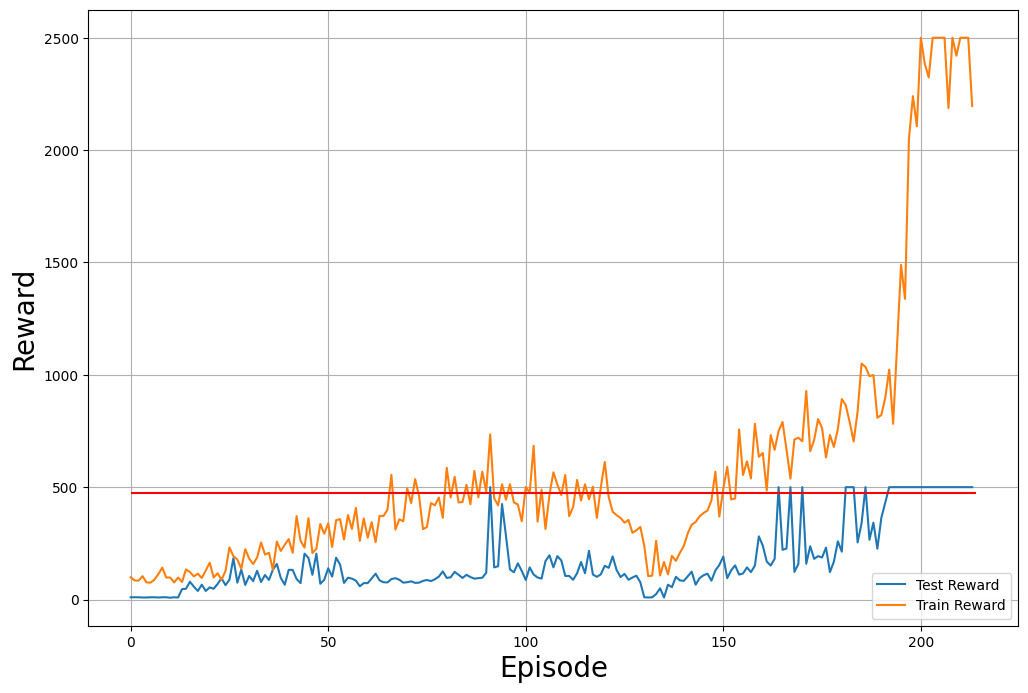

In [27]:
plt.figure(figsize=(12,8))
plt.plot(test_rewards, label='Test Reward')
plt.plot(train_rewards, label='Train Reward')
plt.xlabel('Episode', fontsize=20)
plt.ylabel('Reward', fontsize=20)
plt.hlines(REWARD_THRESHOLD, 0, len(test_rewards), color='r')
plt.legend(loc='lower right')
plt.grid()
plt.show()